# Importing necessary packages

In [62]:
!pip3 install matplotlib

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import random
from PIL import Image

# Storing locations of test and training data

In [3]:
TRAIN_DIR = '/Users/koushikmukka/Downloads/archive/train'
TEST_DIR = '/Users/koushikmukka/Downloads/archive/test'

IMG_DIM = 32
lst = os.listdir(TRAIN_DIR)
if '.DS_Store' in lst:
    lst.remove('.DS_Store')
LABELS = np.asarray(lst)
print(LABELS)

['REAL' 'FAKE']


# Creating training data set

In [4]:
keras.utils.image_dataset_from_directory

<function keras.utils.image_dataset.image_dataset_from_directory(directory, labels='inferred', label_mode='int', class_names=None, color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=None, validation_split=None, subset=None, interpolation='bilinear', follow_links=False, crop_to_aspect_ratio=False, **kwargs)>

In [6]:
from keras.utils import image_dataset_from_directory

#returns tf.data.dataset object which might have multiple components,with label_mode =binary because binary classification is used/required
trainDataSet = image_dataset_from_directory(directory = TRAIN_DIR,
                                             label_mode = 'binary',
                                             image_size = (32, 32))
testDataSet = image_dataset_from_directory(directory = TEST_DIR,label_mode = 'binary',image_size = (32,32))




Found 100350 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.


In [7]:
trainDataSet

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [13]:
trainDataSet_iterator = trainDataSet.as_numpy_iterator()
batch = trainDataSet_iterator.next()
print(batch[0].shape)
print(batch[1].shape)

(32, 32, 32, 3)
(32, 1)


In [14]:
print(batch[1])

[[0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


# Examples of images in given dataset

In [15]:
print(trainDataSet.class_names)

['FAKE', 'REAL']


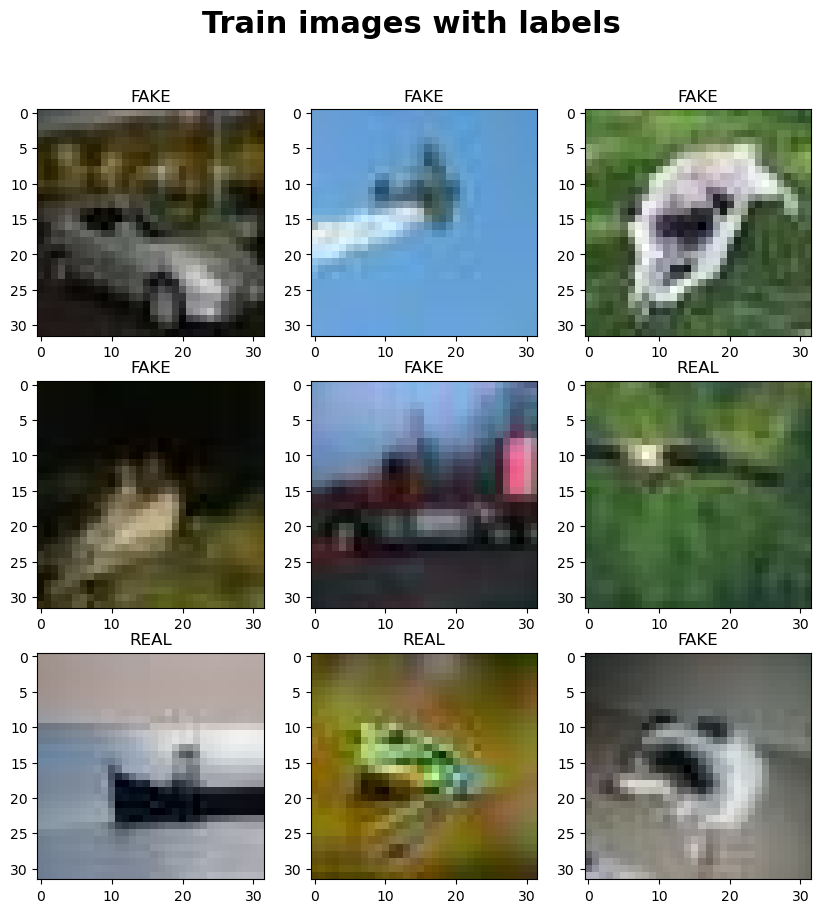

In [16]:
#returns a list of class names in stored dataset
#here real and fake classes inside train
classNames = trainDataSet.class_names

plt.figure(figsize=(10, 10))
plt.suptitle('Train images with labels',
             fontweight = 'bold',
            fontsize = 22)
for images, labels in trainDataSet.take(9):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)#.numpy returns np.ndarray
        plt.imshow(images[i].numpy().astype('uint8'))#arrays representing rgb images have uint8 datatype
        labelIndex = int(labels[i]) # gets the index value
        plt.title(LABELS[labelIndex])
plt.show()

# Preprocessing of given images

In [17]:
keras.preprocessing.image.ImageDataGenerator??

In [18]:
from keras.preprocessing.image import ImageDataGenerator
#The ImageDataGenerator class allows your model to receive new variations of the images at each epoch
#It is data augmentation
# Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data
#No other image augementation.
TRAIN_IMAGE_GENERATOR = ImageDataGenerator(rescale = 1./255)
TEST_IMAGE_GENERATOR = ImageDataGenerator(rescale = 1./255)


TRAIN_GENERATOR_RGB = TRAIN_IMAGE_GENERATOR.flow_from_directory(
    TRAIN_DIR,
    target_size = (32, 32),
    class_mode = 'binary',
    color_mode = 'rgb' 
)

TEST_GENERATOR_RGB = TEST_IMAGE_GENERATOR.flow_from_directory(
    TEST_DIR,
    target_size = (32, 32),
    class_mode = 'binary',
    color_mode = 'rgb' 
)

#Returns a DirectoryIterator object.

Found 100350 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# Building model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, Flatten,Dropout
from keras.layers.activation import *
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
from keras.metrics import BinaryAccuracy
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import convnext

In [20]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 64)                7

In [23]:
model.fit(TRAIN_GENERATOR_RGB,
                    epochs = 1,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

3136/3136 [==============================] - 86s 27ms/step - loss: 0.3285 - accuracy: 0.8565 - val_loss: 0.2379 - val_accuracy: 0.9005


In [24]:
opt=keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [25]:
model_history=model.fit(TRAIN_GENERATOR_RGB,
                    epochs = 30,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

Epoch 1/30
3136/3136 [==============================] - 83s 26ms/step - loss: 0.2109 - accuracy: 0.9163 - val_loss: 0.2118 - val_accuracy: 0.9131
Epoch 2/30
3136/3136 [==============================] - 76s 24ms/step - loss: 0.2039 - accuracy: 0.9196 - val_loss: 0.2047 - val_accuracy: 0.9175
Epoch 3/30
3136/3136 [==============================] - 97s 31ms/step - loss: 0.2013 - accuracy: 0.9210 - val_loss: 0.2098 - val_accuracy: 0.9151
Epoch 4/30
3136/3136 [==============================] - 101s 32ms/step - loss: 0.1987 - accuracy: 0.9218 - val_loss: 0.2032 - val_accuracy: 0.9176
Epoch 5/30
3136/3136 [==============================] - 93s 30ms/step - loss: 0.1962 - accuracy: 0.9228 - val_loss: 0.1983 - val_accuracy: 0.9191
Epoch 6/30
3136/3136 [==============================] - 93s 30ms/step - loss: 0.1943 - accuracy: 0.9236 - val_loss: 0.1963 - val_accuracy: 0.9209
Epoch 7/30
3136/3136 [==============================] - 92s 29ms/step - loss: 0.1929 - accuracy: 0.9244 - val_loss: 0.1961 

In [63]:
model.evaluate(TEST_GENERATOR_RGB)

625/625 [==============================] - 10s 15ms/step - loss: 0.1790 - accuracy: 0.9296


[0.17901043593883514, 0.9296000003814697]

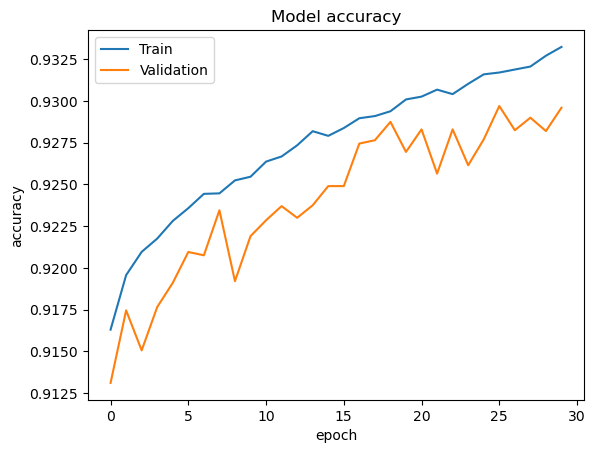

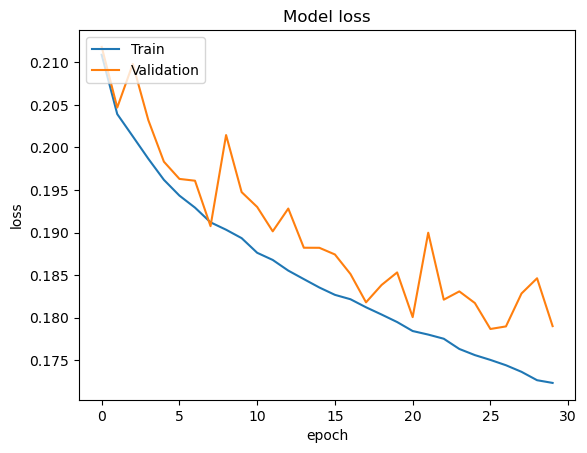

In [26]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.style.use('default')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.style.use('default')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [64]:
tf.keras.models.save_model(model,'my_model2.hdf5')#saves architecture and weights,so that it can be directly use in web application


In [47]:
!pip3 install streamlit

In [74]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
st.set_option('deprecation.showfileUploaderEncoding',False)
class_names = ['Fake','Real']
@st.cache_data#so that we dont need to load the model each time
def load_model():
  model=tf.keras.models.load_model('/Users/koushikmukka/Desktop/my_model2.hdf5')
  return model


with st.spinner('Model is being loaded..'):
  model=load_model()

st.write(
         """
         # AI-Real Image Classification
         """
         )

file = st.file_uploader("Please upload image to check if its real or ai generated", type=["jpg", "png"])

import cv2
from PIL import Image, ImageOps
import numpy as np
def import_and_predict(image_data, model):
        size = (32,32)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_reshape = img[np.newaxis,...]#model is trained on 4dimensions,this line adds new dimension
        prediction = model.predict(img_reshape)        
        return prediction

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)#display 
    predictions = import_and_predict(image, model)
    score = tf.nn.sigmoid(predictions[0])
    st.write(predictions)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)



Overwriting app.py


t=2023-06-22T19:49:34+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=554996eccd52 clientid=b38aee3bf11fcfa5f8758c7239448b86
t=2023-06-22T19:49:34+0530 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="session closed"
t=2023-06-22T21:06:26+0530 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="read tcp 192.168.29.26:61748->3.134.73.173:443: read: operation timed out"
t=2023-06-22T21:23:08+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=0fbdd470654a clientid=b38aee3bf11fcfa5f8758c7239448b86
t=2023-06-22T21:30:29+0530 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=6796d789008e clientid=b38aee3bf11fcfa5f8758c7239448b86
t=2023-06-22T21:30:29+0530 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="ses

t=2023-06-23T09:52:06+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T10:57:54+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T12:05:29+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T12:28:13+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T12:28:43+0530 l

t=2023-06-23T12:43:13+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T12:43:43+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T12:44:13+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T12:44:43+0530 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=bf8f92cb5a49 err="failed to dial ngrok server with address \"tunnel.us.ngrok.com:443\": dial tcp: lookup tunnel.us.ngrok.com: no such host"
t=2023-06-23T13:42:04+0530 l

In [58]:
!pip3 install -U ipykernel

In [59]:
!pip3 install pyngrok

In [60]:
!ngrok authtoken 2RYcIvS2TsvM9sZH28g7CQRxNQK_59rVX9pXvqJSKByrgdyyt

Authtoken saved to configuration file: /Users/koushikmukka/.ngrok2/ngrok.yml


zsh:1: no such file or directory: ./ngrok


# Dropout Regularization

In [27]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_uniform', padding='same'))
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [28]:
opt=keras.optimizers.SGD(learning_rate=0.001)
model2.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [29]:
model2.fit(TRAIN_GENERATOR_RGB,
                    epochs = 1,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

3136/3136 [==============================] - 120s 38ms/step - loss: 0.6584 - accuracy: 0.6105 - val_loss: 0.6097 - val_accuracy: 0.6448


In [48]:
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 32)        

# Transfer learning

In [17]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# without fine tuning

In [18]:
vgg_model = create_model((32,32,3), 1,'adam', fine_tune=0)

In [19]:
vgg_model.fit(TRAIN_GENERATOR_RGB,
                    epochs = 1,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

3136/3136 [==============================] - 1390s 443ms/step - loss: 0.3646 - accuracy: 0.8385 - val_loss: 0.3251 - val_accuracy: 0.8599


In [ ]:
vgg_model.compile(optimizer=opt, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [35]:
vgg_model.fit(TRAIN_GENERATOR_RGB,
                    epochs = 1,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

3136/3136 [==============================] - 1347s 429ms/step - loss: 0.2907 - accuracy: 0.8776 - val_loss: 0.3011 - val_accuracy: 0.8711


In [20]:
vgg_model2 = create_model((32,32,3),1,opt,fine_tune=0)

In [21]:
vgg_model2.fit(TRAIN_GENERATOR_RGB,
                    epochs = 1,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

3136/3136 [==============================] - 1327s 423ms/step - loss: 0.5511 - accuracy: 0.7317 - val_loss: 0.4925 - val_accuracy: 0.7669


In [22]:
def create_model2(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(64, activation='relu')(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [23]:
vgg_model3 = create_model((32,32,3),1,opt,fine_tune=0)

In [24]:
vgg_model3.fit(TRAIN_GENERATOR_RGB,
                    epochs = 1,
                    validation_data = TEST_GENERATOR_RGB,
                    batch_size = 64
                   )

3136/3136 [==============================] - 1499s 478ms/step - loss: 0.5583 - accuracy: 0.7266 - val_loss: 0.4988 - val_accuracy: 0.7611
